# ***OCON Model Analysis***
*(13-features Complete Dataset - Speaker Recognition)*

**Author:** S. Giacomelli

**Year:** 2023

**Affiliation:** A.Casella Conservatory (student)

**Master Degree Thesis**: "*Vowel phonemes Analysis & Classification by means of OCON rectifiers Deep Learning Architectures*"

**Description:** Python scripts for One-Class-One-Network (OCON) Model analysis and optimization

In [ ]:
# Numerical computations packages/modules
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Dataset processing modules
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Graphic visualization modules
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Common Seed initialization
SEED = 42  # ... the answer to the ultimate question of Life, the Universe, and Everything... (cit.)

# PyTorch Processing Units evaluation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'AVILABLE Processing Unit: {device.upper()}')
!nvidia-smi

AVILABLE Processing Unit: CPU
/bin/bash: nvidia-smi: command not found


## **HGCW Dataset**

- *Dataset_utils.npz* file read
- *One-Hot encoding* definition
- *Train/Dev/Test split* definition

In [ ]:
# Load HGCW 13_features_complete_(w_speaker) Dataset
HGCW_dataset_utils = np.load(file='./HGCW_dataset_utils.npz')
print('Raw features                    Data shape:', HGCW_dataset_utils['HGCW_raw'].shape)
print('Fundamental Normalized features Data shape:', HGCW_dataset_utils['HGCW_fund_norm'].shape)
print('MinMax features                 Data shape:', HGCW_dataset_utils['HGCW_minmax'].shape)
print('Phoneme Labels                  Data shape:', HGCW_dataset_utils['HGCW_phon_labels'].shape)
print('Speaker Labels                  Data shape:', HGCW_dataset_utils['HGCW_spk_labels'].shape)
print('Phoneme Classes size            Data shape:', HGCW_dataset_utils['phon_size'].shape)
print('Phoneme Classes indices         Data shape:', HGCW_dataset_utils['phon_idx'].shape)
print('Phoneme-Speaker coordinates     Data shape:', HGCW_dataset_utils['phon_spk_coords'].shape)  # (Start_Idx, Vow-Spk group size)

x_data_raw_np = HGCW_dataset_utils['HGCW_raw']
x_data_fund_norm = HGCW_dataset_utils['HGCW_fund_norm']
x_data_minmax = HGCW_dataset_utils['HGCW_minmax']
y_labels_raw_np = HGCW_dataset_utils['HGCW_phon_labels']
z_labels_raw_np = HGCW_dataset_utils['HGCW_spk_labels']
vow_size = HGCW_dataset_utils['phon_size']
end_idx = HGCW_dataset_utils['phon_idx']
phon_spk_coords = HGCW_dataset_utils['phon_spk_coords']

# Auxiliary lists
vowels = ['ae', 'ah', 'aw', 'eh', 'er', 'ei', 'ih', 'iy', 'oa', 'oo', 'uh', 'uw']  # Vowels list (0 - 11)
speakers = ['b', 'g', 'm', 'w']  # Speakers list (0 - 3)
colors = ['green', 'blue', 'red']  # ['red', 'saddlebrown', 'darkorange', 'darkgoldenrod', 'gold', 'darkkhaki', 'olive', 'darkgreen', 'steelblue', 'fuchsia', 'indigo', 'black']

Raw features                    Data shape: (1597, 13)
Fundamental Normalized features Data shape: (1597, 13)
MinMax features                 Data shape: (1597, 13)
Phoneme Labels                  Data shape: (1597, 1)
Speaker Labels                  Data shape: (1597, 1)
Phoneme Classes size            Data shape: (12,)
Phoneme Classes indices         Data shape: (13,)
Phoneme-Speaker coordinates     Data shape: (12, 4, 2)


In [ ]:
# Fundamental Frequency - Min-Max Scaling
print(f'Previous Fundamental Frequency Min: {x_data_minmax[:, 0].min()}, Max: {x_data_minmax[:, 0].max()}')
x_data_minmax[:, 0] = (x_data_minmax[:, 0] - x_data_minmax[:, 0].min()) / (x_data_minmax[:, 0].max() - x_data_minmax[:, 0].min())
print(f'Actual Fundamental Frequency Min: {x_data_minmax[:, 0].min()}, Max: {x_data_minmax[:, 0].max()}')

Previous Fundamental Frequency Min: 90.0, Max: 330.0
Actual Fundamental Frequency Min: 0.0, Max: 1.0


In [ ]:
# Children Labels encoding
z_labels_raw_np_alt = np.where(z_labels_raw_np <= 1, 0, z_labels_raw_np - 1)
speakers_alt = ['c', 'm', 'w']

In [ ]:
def one_hot_encoder(sel_speaker_num=0, dataset=x_data_minmax, spk_labels=z_labels_raw_np_alt, speakers=speakers_alt, debug=False):

    if sel_speaker_num < len(speakers):
        classes = [n for n in range(len(speakers))]  # Speaker indices
        sub_groups_size = []  # Same as vow_size list

        sub_data_one = dataset[np.where(spk_labels == sel_speaker_num)[0], :]  # Extract selected speaker sub-dataset
        sub_labels_one = np.ones((sub_data_one.shape[0], 1), dtype='int')  # Binarized 1-Label creation
        sub_labels_one_orig = np.ones((sub_data_one.shape[0], 1), dtype='int') * sel_speaker_num  # Create a copy of original labels
        sub_groups_size.append(sub_data_one.shape[0])
        if debug is True:
            print(f'Selected Class "{speakers[sel_speaker_num]}"-speaker : {sub_data_one.shape[0]} samples')

        sub_speakers_size = sub_data_one.shape[0] // 2  # Size for each other speaker sub-group (balancing)
        if debug is True:
            print(f'Rest Classes size (...each): {sub_speakers_size} samples')

        sub_data_zero = np.zeros((sub_speakers_size * 2, sub_data_one.shape[1]))  # Zero-label features dataset initialization
        sub_labels_zero_orig = np.zeros((sub_speakers_size * 2, 1), dtype='int')  # Original labels subset array initialization

        classes.remove(sel_speaker_num)  # Remove selected speaker index
        counter = 0
        for i in classes:  # For other speakers...
            sub_data_zero_class =  dataset[np.where(spk_labels == i)[0], :]  # Extract speaker subgroup
            subset_indices = np.random.choice(np.arange(0, sub_data_zero_class.shape[0], 1), size=sub_speakers_size, replace=False)  # Compute random indices from subgroup array length

            sub_data_zero[counter * sub_speakers_size : (counter * sub_speakers_size) + sub_speakers_size, :] = sub_data_zero_class[subset_indices]  # Vertical stacking of random samples from actual speaker subgroup
            sub_labels_zero_orig[counter * sub_speakers_size : (counter * sub_speakers_size) + sub_speakers_size, :] = np.ones((sub_data_zero_class[subset_indices].shape[0], 1), dtype='int') * i  # Vertical stacking of a copy of actual subgroup oiriginal labels
            sub_groups_size.append(sub_data_zero_class[subset_indices].shape[0])

            counter += 1

        sub_labels_zero = np.zeros((sub_data_zero.shape[0], 1), dtype='int')  # Binarized 0 Label creation

        # Output Matrices
        sub_data = np.vstack((sub_data_one, sub_data_zero))  # Vertical stacking 1s and 0s features array
        sub_data_labels_bin = np.vstack((sub_labels_one, sub_labels_zero))  # Vertical Stacking 1s and 0s labels array
        sub_data_labels_orig = np.vstack((sub_labels_one_orig, sub_labels_zero_orig))  # Vertical stacking original (1-class) and original (0s-class) labels
    else:
        raise ValueError(f'Invalid Class ID: "{sel_speaker_num}" --> It must be less than {len(speakers)}!')

    return sub_data, sub_data_labels_bin, sub_data_labels_orig, sub_groups_size

# Test Call
sel_speaker_num = 0
sub_data, sub_data_labels_bin, sub_data_labels_orig, sub_groups_size = one_hot_encoder(sel_speaker_num, dataset=x_data_minmax, spk_labels=z_labels_raw_np_alt, speakers=speakers_alt, debug=True)
print(f'Output Array shapes: {sub_data.shape}, {sub_data_labels_bin.shape}, {sub_data_labels_orig.shape}, {len(sub_groups_size)}')

Selected Class "c"-speaker : 522 samples
Rest Classes size (...each): 261 samples
Output Array shapes: (1044, 13), (1044, 1), (1044, 1), 3


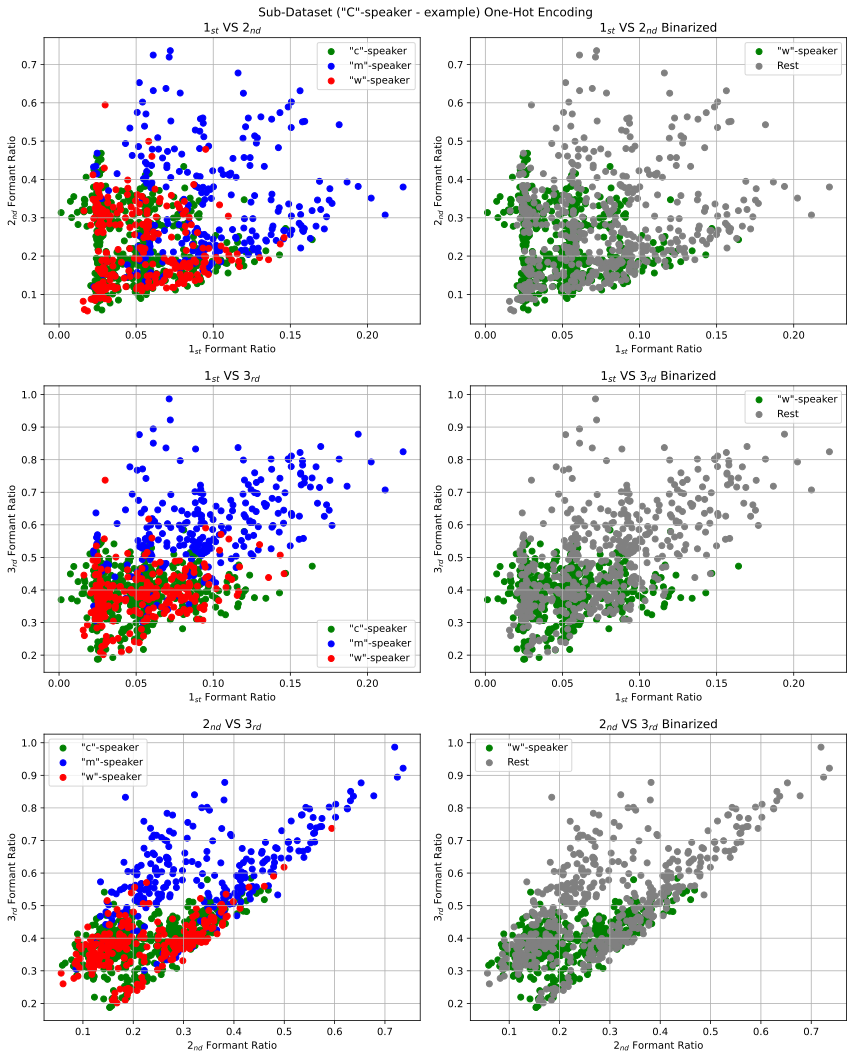

In [ ]:
# Sub-Dataset Plot (previous example)
classes = [n for n in range(len(speakers_alt))]

plt.figure(figsize=(12, 15))
plt.suptitle(f'Sub-Dataset ("{speakers_alt[sel_speaker_num].upper()}"-speaker - example) One-Hot Encoding')

counter = 0
for index in range(len(speakers_alt)):
    if index == sel_speaker_num:
        first_coords = sub_data[:sub_groups_size[0], 1]
        second_coords = sub_data[:sub_groups_size[0], 2]
        third_coords = sub_data[:sub_groups_size[0], 3]
    else:
        start_index = sub_groups_size[0] + counter * sub_groups_size[1]
        end_index = start_index + sub_groups_size[1]

        first_coords = sub_data[start_index: end_index, 1]
        second_coords = sub_data[start_index: end_index, 2]
        third_coords = sub_data[start_index: end_index, 3]

        counter += 1

    plt.subplot(3, 2, 1)
    plt.title('$1_{st}$ VS $2_{nd}$')
    plt.scatter(first_coords, second_coords, marker='o', color=colors[index], label=f'"{speakers_alt[index]}"-speaker')
    plt.xlabel('$1_{st}$ Formant Ratio')
    plt.ylabel('$2_{nd}$ Formant Ratio')
    plt.legend(loc='best')
    plt.grid(True)

    plt.subplot(3, 2, 3)
    plt.title('$1_{st}$ VS $3_{rd}$')
    plt.scatter(first_coords, third_coords, marker='o', color=colors[index], label=f'"{speakers_alt[index]}"-speaker')
    plt.xlabel('$1_{st}$ Formant Ratio')
    plt.ylabel('$3_{rd}$ Formant Ratio')
    plt.legend(loc='best')
    plt.grid(True)

    plt.subplot(3, 2, 5)
    plt.title('$2_{nd}$ VS $3_{rd}$')
    plt.scatter(second_coords, third_coords, marker='o', color=colors[index], label=f'"{speakers_alt[index]}"-speaker')
    plt.xlabel('$2_{nd}$ Formant Ratio')
    plt.ylabel('$3_{rd}$ Formant Ratio')
    plt.legend(loc='best')
    plt.grid(True)

plt.subplot(3, 2, 2)
plt.title('$1_{st}$ VS $2_{nd}$ Binarized')
plt.scatter(sub_data[0: sub_groups_size[0], 1], sub_data[0: sub_groups_size[0], 2], color=colors[sel_speaker_num], label=f'"{speakers_alt[index]}"-speaker')
plt.scatter(sub_data[sub_groups_size[0]: , 1], sub_data[sub_groups_size[0]: , 2], color='grey', label=f'Rest')
plt.xlabel('$1_{st}$ Formant Ratio')
plt.ylabel('$2_{nd}$ Formant Ratio')
plt.legend(loc='best')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.title('$1_{st}$ VS $3_{rd}$ Binarized')
plt.scatter(sub_data[0: sub_groups_size[0], 1], sub_data[0: sub_groups_size[0], 3], color=colors[sel_speaker_num], label=f'"{speakers_alt[index]}"-speaker')
plt.scatter(sub_data[sub_groups_size[0]: , 1], sub_data[sub_groups_size[0]: , 3], color='grey', label=f'Rest')
plt.xlabel('$1_{st}$ Formant Ratio')
plt.ylabel('$3_{rd}$ Formant Ratio')
plt.legend(loc='best')
plt.grid(True)

plt.subplot(3, 2, 6)
plt.title('$2_{nd}$ VS $3_{rd}$ Binarized')
plt.scatter(sub_data[0: sub_groups_size[0], 2], sub_data[0: sub_groups_size[0], 3], color=colors[sel_speaker_num], label=f'"{speakers_alt[index]}"-speaker')
plt.scatter(sub_data[sub_groups_size[0]: , 2], sub_data[sub_groups_size[0]: , 3], color='grey', label=f'Rest')
plt.xlabel('$2_{nd}$ Formant Ratio')
plt.ylabel('$3_{rd}$ Formant Ratio')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.savefig(f'{speakers_alt[sel_speaker_num]}_speaker_one_hot_encoding')
plt.show()

In [ ]:
# Train/Test split (auxiliary function)
def train_test_split_aux(features_dataset, labels_dataset, test_perc, tolerance):
    """
    An auxiliary Train_Test_split function (based on Scikit Learn implementation) w. balance tolerance specification
    """
    test_size = int(test_perc / 100 * len(features_dataset))
    train_balance = 0  # Output Training set balance value initialization
    test_balance = 0  # Output Testing set balance value initialization

    min_tol = np.mean(labels_dataset) - tolerance
    max_tol = np.mean(labels_dataset) + tolerance
    print(f'Data Balancing  (TARGET = {np.mean(labels_dataset)} +- {tolerance}): ', end='')

    while (min_tol >= train_balance or train_balance >= max_tol) or (min_tol >= test_balance or test_balance >= max_tol):
        train_data, test_data, train_labels, test_labels = train_test_split(features_dataset, labels_dataset, test_size=test_size, shuffle=True)
        train_balance = np.mean(train_labels)
        test_balance = np.mean(test_labels)
        print('.', end='')
    else:
        print('OK')

    return train_data, test_data, train_labels, test_labels, train_balance, test_balance

# Train-Dev-Test split function
def train_dev_test_split(x_data, y_labels, split_list, tolerance=0.1, output='Loaders', debug=False):
    """
    Compute a Train, Development (Hold-Out) and a Test set split w. PyTorch Dataset conversion (and eventual Loaders initialization)
    """
    if len(split_list) == 3:
        # Train - Dev+Test separation
        print('Training --- Devel/Test SPLIT')
        train_data, testTMP_data, train_labels, testTMP_labels, _, _ = train_test_split_aux(x_data, y_labels, (split_list[1] * 100) + (split_list[2] * 100), tolerance)
        print('----------------------------------')

        # Dev - Test separation
        print('Devel    ---     Test SPLIT')

        split = ((split_list[1] * 100) / np.sum(split_list[1:] * 100)) * 100  # Split in %
        dev_data, test_data, dev_labels, test_labels, _, _ = train_test_split_aux(testTMP_data, testTMP_labels, split, tolerance)
        print('----------------------------------')

        # Tensor Conversion
        train_data_tensor = torch.tensor(train_data).float()
        train_labels_tensor = torch.tensor(train_labels, dtype=torch.int64).squeeze()
        dev_data_tensor = torch.tensor(dev_data).float()
        dev_labels_tensor = torch.tensor(dev_labels, dtype=torch.int64).squeeze()
        test_data_tensor = torch.tensor(test_data).float()
        test_labels_tensor = torch.tensor(test_labels, dtype=torch.int64).squeeze()
        if debug is True:
            print(f'Training Data        Shape: {train_data.shape}')
            print(f'Development Data     Shape: {dev_data.shape}')
            print(f'Testing Data         Shape: {test_data.shape}')

            # Balance Evaluation
            print(f'Training Set       Balance: {np.mean(train_labels)}')
            print(f'Development Set    Balance: {np.mean(dev_labels)}')
            print(f'Testing Set        Balance: {np.mean(test_labels)}')

        if output != 'Loaders':
            return train_data_tensor, train_labels_tensor, dev_data_tensor, dev_labels_tensor, test_data_tensor, test_labels_tensor
        else:
            # PyTorch Dataset Conversion
            train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_labels, dtype=torch.int64).squeeze())
            dev_dataset = torch.utils.data.TensorDataset(torch.tensor(dev_data).float(), torch.tensor(dev_labels, dtype=torch.int64).squeeze())
            test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_data).float(), torch.tensor(test_labels, dtype=torch.int64).squeeze())

            # DataLoader (Batches) --> Drop-Last control to optimize training
            trainLoader = DataLoader(train_dataset, shuffle=False, batch_size = 32, drop_last=True)
            devLoader = DataLoader(dev_dataset, shuffle=False, batch_size = dev_dataset.tensors[0].shape[0])
            testLoader = DataLoader(test_dataset, shuffle=False, batch_size = test_dataset.tensors[0].shape[0])
            if debug is True:
                print(f'Training Set    Batch Size: {trainLoader.batch_size}')
                print(f'Development Set Batch Size: {devLoader.batch_size}')
                print(f'Testing Set     Batch Size: {testLoader.batch_size}')

            return trainLoader, devLoader, testLoader
    else:
        # Train - Test separation
        print('Training --- Test    SPLIT')
        train_data, test_data, train_labels, test_labels, _, _ = train_test_split_aux(x_data, y_labels, split_list[1] * 100, tolerance, debug=debug)
        print('--------------------------')

        # Tensor Conversion
        train_data_tensor = torch.tensor(train_data).float()
        train_labels_tensor = torch.tensor(train_labels, dtype=torch.int64).squeeze()
        test_data_tensor = torch.tensor(test_data).float()
        test_labels_tensor = torch.tensor(test_labels, dtype=torch.int64).squeeze()
        if debug is True:
            print(f'Training Data        Shape: {train_data.shape}')
            print(f'Testing Data         Shape: {test_data.shape}')

            # Balance Evaluation
            print(f'Training Set    Balance: {np.mean(train_labels)}')
            print(f'Testing Set     Balance: {np.mean(test_labels)}')

        if output != 'Loaders':
            return train_data_tensor, train_labels_tensor, test_data_tensor, test_labels_tensor
        else:
            # PyTorch Dataset Conversion
            train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_labels, dtype=torch.int64).squeeze())
            test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_data).float(), torch.tensor(test_labels, dtype=torch.int64).squeeze())

            # DataLoader (Batches) --> Drop-Last control to optimize training
            trainLoader = DataLoader(train_dataset, shuffle=False, batch_size = 32, drop_last=True)
            testLoader = DataLoader(test_dataset, shuffle=False, batch_size = test_dataset.tensors[0].shape[0])
            if debug is True:
                print(f'Training Set    Batch Size: {trainLoader.batch_size}')
                print(f'Testing Set     Batch Size: {testLoader.batch_size}')

            return trainLoader, testLoader

## **One-Class Architecture** (Binary Classifier)
(see "*One-Class_Sub-Network_Analysis.ipynb*")

```
Multi-Layer Perceptron
- Input Layer: 3 features [formant ratios, min-max normalized]
- Hidden Layer: 100 units
- Output Layer: 1 normalized probability
- Learning Rate: 0.0001 (10^-4)
- Optimizer: Adam (Adaptive Momentum)

- Mini-Batch Training:
    . Re-iterated Sub-Dataset Shuffling
    . Early Stopping (Test Accuracy driven)
    . Batch size = 32

- Regularization:
    . Weight Decay (L2 Penalty): 0.0001 (10^-4)
    . DropOut:
        * Input Layer Drop Rate: 0.8
        * Hidden Layer Drop Rate: 0.5.
    . Batch Normalization
```

- *MLP Classifier Architecture* class definition
- *Mini-Batch Training* function definition

In [ ]:
# Dynamic Multi-Layer Architecture Class (w. units, activation function, batch normalization and dropOut rate specification)
class binaryClassifier(nn.Module):                                                # nn.Module: base class to inherit from
    def __init__(self, n_units, act_fun, rate_in, rate_hidden, model_name):       # self + attributes (architecture hyper-parameters)
        super().__init__()

        self.layers = nn.ModuleDict()                                             # Dictionary to store Model layers
        self.name = model_name

        # Input Layer
        self.layers['input'] = nn.Linear(13, n_units)                              # Key 'input' layer specification

        # Hidden Layer
        self.layers[f'hidden'] = nn.Linear(n_units, n_units)
        self.layers[f'batch_norm'] = nn.BatchNorm1d(n_units)

        # Output Layer
        self.layers['output'] = nn.Linear(n_units, 1)                             # Key 'output' layer specification

        # Activation Function
        self.actfun = act_fun                                                     # Function string-name attribute association

        # Dropout Parameter
        self.dr_in = rate_in
        self.dr_hidden = rate_hidden

        # Weights & Bias initialization
        for layer in self.layers.keys():
            try:
                nn.init.kaiming_normal_(self.layers[layer].weight, mode='fan_in') # Kaiming He - Normal Distributed (ReLU specific)
            except:
                pass                                                              # Batch_norm Layer can't be initialized
            self.layers[layer].bias.data.fill_(0.)                                # Bias initialization (0.)

    # Forward Pass Method
    def forward(self, x):

        # Activation function object computation
        actfun = getattr(torch.nn, self.actfun)

        # Input Layer pass                                                        --> Weightening (Dot Product) "Linear transform" + "Non linear function" transform application
        x = actfun()(self.layers['input'](x))
        x = F.dropout(x, p=self.dr_in, training=self.training)                    # Activate DropOut only when Model Training == True

        # Single Hidden Layer pass                                                --> Weightening (Dot Product) "Linear transform" + "Non linear function" transform application
        x = self.layers[f'batch_norm'](x)                                         # Apply batch normalization before hidden layer
        x = actfun()(self.layers[f'hidden'](x))
        x = F.dropout(x, p=self.dr_hidden, training=self.training)                # Same as "Input pass"

        # Output Layer pass                                                       --> Output Weightening (Dot Product) "Linear transform" (Optimizer implement an Output Sigmoid sctivation)
        x = self.layers['output'](x)
        x = nn.Sigmoid()(x)

        return x

In [ ]:
# Batch Training function (w. Adam Optimizer & L2 penalty term) Re-Definition
def mini_batch_train_test(model, weight_decay, epochs: int, learning_rate, train_loader, dev_loader, test_loader, debug=False):
    """
    Train & Test an ANN Architecture via Mini-Batch Training (w. Train/Dev/Test PyTorch Loaders) and Adam Backpropagation Optimizer
    """
    # Loss Function initialization
    loss_function = nn.BCELoss()

    # Optimizer Algorithm initialization
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Output list initialization
    train_accuracies = []
    train_losses = []
    dev_accuracies = []

    # TRAINING Phase
    for epoch in range(epochs):
        model.train()  # TRAINING Switch ON

        batch_accuracies = []
        batch_losses = []

        # Training BATCHES Loop
        for data_batch, labels_batch in train_loader:
            train_predictions = model(data_batch)
            train_loss = loss_function(train_predictions.squeeze(), labels_batch.type(torch.int64).float())
            batch_losses.append(train_loss.detach())

            # Backpropagation
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # Accuracy
            train_accuracy = 100 * torch.mean(((train_predictions.squeeze() > 0.5) == labels_batch.type(torch.int64).squeeze()).float())

            # Batch Stats appending
            batch_accuracies.append(train_accuracy.detach())
            batch_losses.append(train_loss.detach())

        # Training Stats appending
        train_accuracies.append(np.mean(batch_accuracies))  # Average of Batch Accuracies = Training step accuracy
        train_losses.append(np.mean(batch_losses))  # Average of Batch Losses = Training step Losses

        # EVALUATION (Dev) Phase
        model.eval()
        with torch.no_grad():
            dev_data_batch, dev_labels_batch = next(iter(dev_loader))
            dev_predictions = model(dev_data_batch)

            dev_accuracy = 100 * torch.mean(((dev_predictions.squeeze() > 0.5) == dev_labels_batch.type(torch.int64).squeeze()).float())

            if debug is True:
                if epoch % 100 == 0:
                    print(f'Epoch {epoch} --> DEV ACCURACY: {dev_accuracy.detach():.3f} %')
                    print('--------------------------------')

            # Evaluation accuracy appending
            dev_accuracies.append(dev_accuracy.detach())

    # TEST Phase
    model.eval()
    with torch.no_grad():
        test_data_batch, test_labels_batch = next(iter(test_loader))
        test_predictions = model(test_data_batch)
        test_accuracy = 100 * torch.mean(((test_predictions.squeeze() > 0.5) == test_labels_batch.type(torch.int64).squeeze()).float())

        if debug is True:
            print(f'TEST ACCURACY: {test_accuracy.detach():.2f} %')
            print('--------------------------------------------------------------------')

    return train_accuracies, train_losses, dev_accuracies, test_accuracy.detach()

## **OCON (One-Class-One-Net)** Model

Binary classifiers **Parallelization**
-  *Classifiers-Bank* function definition
    - *Models Parameters* inspection
- Classifiers **Sequential** Training & Evaluation
- *Models Parameters State Save/Load* function definition

---

- MaxNet output algorithm
- Argmax output algorithm

In [ ]:
def OCON_bank(one_class_function, hidden_units, act_fun, dr_in, dr_hidden, classes_list):
    """
    Create a One-Class-One-Network parallelization bank of an input Sub-Network definition
    """
    # Sub-Net names creation
    models_name_list = []
    for i in range(len(classes_list)):
        models_name_list.append("{}_{}".format(classes_list[i], "subnet"))  # Class name + _subnet

    # Sub-Networks instances creation
    sub_nets = []  # Sub Network list initialization

    for i in range(len(models_name_list)):

        torch.manual_seed(SEED)  # Seed re-initialization

        # Sub-Net instance creation
        locals()[models_name_list[i]] = one_class_function(hidden_units, act_fun, dr_in, dr_hidden, models_name_list[i])
        sub_nets.append(locals()[models_name_list[i]])

    return sub_nets

In [ ]:
# Load Architecture Parameters State function
def load_model_state(model, state_dict_path):
    """
    Load an existent State Dictionary in a defined model
    """

    model.load_state_dict(torch.load(state_dict_path))
    print(f'Loaded Parameters (from "{state_dict_path}") into: {model.name}')

    return model

In [ ]:
# Build The OCON Model
ocon_speakers = OCON_bank(binaryClassifier, 100, 'ReLU', 0.8, 0.5, speakers_alt)  # Best MLP (see "One-Class_Binary_Classifier_Analysis.ipynb")

# Load Pre-Trained Architectures in a fresh Model instance:
#ocon_vowels = OCON_bank(binaryClassifier, 100, 'ReLU', 0.8, 0.5, speaker)  # Best MLP (see "One-Class_Binary_Classifier_Analysis.ipynb")
#states_path = ["Trained_models_state/b_subnet_Params.pth",
#               "Trained_models_state/g_subnet_Params.pth",
#               "Trained_models_state/m_subnet_Params.pth",
#               "Trained_models_state/w_subnet_Params.pth"]
#
#for i in range(len(ocon_speakers)):
#    load_model_state(ocon_speakers[i], states_path[i])

In [ ]:
# OCON Evaluation function
def OCON_eval(ocon_models_bank, features_dataset: np.ndarray = x_data_minmax, labels: np.ndarray = z_labels_raw_np_alt):
    """
    Evaluate OCON models-bank over an entire dataset
    """
    # Output lists initialization
    predictions = []
    dist_errors = []
    eval_accuracies = []
    g_truths = []  # For plotting purpouses

    # Evaluate each Sub-Network...
    for i in range(len(ocon_models_bank)):
        ocon_models_bank[i].eval()  # Put j-esimal Sub-Network in Evaluation Mode
        print(f'{ocon_models_bank[i].name.upper()} Evaluation -', end=' ')

        with torch.no_grad():

            # Make predictions
            features_data_tensor = torch.tensor(features_dataset).float()
            raw_eval_predictions = ocon_models_bank[i](features_data_tensor)

            # Create Ground Truths
            ground_truth = np.where(labels == i, 1, 0)
            ground_truth_tensor = torch.tensor(ground_truth, dtype=torch.int64).squeeze()

            # Compute Errors
            dist_error = ground_truth_tensor - raw_eval_predictions.detach().squeeze()  # Distances
            eval_accuracy = 100 * torch.mean(((raw_eval_predictions.detach().squeeze() > 0.5) == ground_truth_tensor).float())
            print(f'Accuracy: {eval_accuracy:.2f}%')

        # Outputs append
        predictions.append(raw_eval_predictions.detach())
        dist_errors.append(dist_error.detach())
        eval_accuracies.append(eval_accuracy.detach())

        g_truths.append(ground_truth)

    return predictions, dist_errors, eval_accuracies, g_truths

# For Pre-Trained Models
#ocon_predictions, ocon_dist_errors, ocon_eval_accuracies, ocon_g_truths = OCON_eval(ocon_speakers)

In [ ]:
# Model Parameters State function
def model_desc(model):
    """
    Print a Console report of Neural Network Model parameters
    """
    # Parameters Description
    print('Params Description:')
    trainable_params = 0

    for parameter in model.named_parameters():
        print(f'Parameter Name      : {parameter[0]}')
        print(f'Parameter Weights   : {parameter[1][:]}')
        if parameter[1].requires_grad:
            print(f'...with {parameter[1].numel()} TRAINABLE parameters')
            trainable_params += parameter[1].numel()

        print('................................')

    print('----------------------------------------------------------------')

    # Nodes Count
    nodes = 0
    for param_name, param_tensor in model.named_parameters():
        if 'bias' in param_name:
            nodes += len(param_tensor)

    print(f'Total Nodes             : {nodes}')
    print('----------------------------------------------------------------')

# OCON-Model Description
for i in range(len(ocon_speakers)):
    print(f'OCON "{ocon_speakers[i].name}" Classifier STATE')
    model_desc(ocon_speakers[i])
    print()

OCON "c_subnet" Classifier STATE
Params Description:
Parameter Name      : layers.input.weight
Parameter Weights   : tensor([[-0.0653, -0.3846, -0.1983,  ..., -0.4772, -0.3196,  0.2005],
        [ 0.8112,  0.2327,  0.7236,  ...,  0.0869, -0.3285,  0.1741],
        [-0.4581, -0.2125, -0.9967,  ..., -0.3721, -0.1501,  0.1738],
        ...,
        [-0.0692, -0.2153, -0.5627,  ...,  0.2163, -0.2065,  0.5857],
        [ 0.3089,  0.3273, -0.2358,  ...,  0.0201,  0.2483,  0.2893],
        [-0.2262, -0.2699,  0.8587,  ..., -1.0004, -0.0816, -0.0196]],
       grad_fn=<SliceBackward0>)
...with 1300 TRAINABLE parameters
................................
Parameter Name      : layers.input.bias
Parameter Weights   : tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
# Training/Eval/Testing Parameters
epochs = 1000  # For each "Data Batch-Set"
loss_breaks = [0.36, 0.08, 0.45]  # loss (for Early Stopping) --> class-specific (empyrical)
acc_breaks = [80., 97., 80.]  # % accuracy (for Early Stopping)  --> class-specific (empyrical)
min_tolerance = 0.01 # ...for sub-dataset balancing

# Outputs Initialization
loss_functions = [[] for _ in range(len(ocon_speakers))]
training_accuracies = [[] for _ in range(len(ocon_speakers))]
evaluation_accuracies = [[] for _ in range(len(ocon_speakers))]
test_accuracies = [[] for _ in range(len(ocon_speakers))]
training_times = []

In [ ]:
# OCON Sub-Networks Training
from time import perf_counter
debug = False

for i, speaker in enumerate(speakers_alt):

    # Class-specific Early Stopping parameters
    loss_break = loss_breaks[i]
    acc_break = acc_breaks[i]

    print(f'Architecture "{ocon_speakers[i].name}" TRAINING PHASE')
    print(f'EARLY STOP THRESHOLD: Loss={loss_break}, Accuracy={acc_break}%')

    start_timer = perf_counter()
    # Iterated (w. Batch-Sets shuffling) Mini-Batch Training
    iteration = 0  # Batch Training iteration counter
    mean_loss = 1.
    test_accuracy = 0.

    while (mean_loss > loss_break) or (test_accuracy < acc_break):
        # Dataset processing
        sub_data, sub_data_labels_bin, _, _ = one_hot_encoder(sel_speaker_num=i, dataset=x_data_minmax, debug=debug)
        print('----------------------------------')
        trainLoader, devLoader, testLoader = train_dev_test_split(sub_data, sub_data_labels_bin, [0.5, 0.25, 0.25], tolerance=min_tolerance, output='Loaders', debug=debug)

        # Train/Test Architecture
        train_accuracies, train_losses, dev_accuracies, test_accuracy = mini_batch_train_test(ocon_speakers[i], weight_decay=0.0001, epochs=epochs, learning_rate=0.0001, train_loader=trainLoader, dev_loader=devLoader, test_loader=testLoader, debug=debug)
        print(f'Sub-Net "{speaker.upper()}" Epoch {(iteration + 1) * epochs} - TEST ACCURACY: {test_accuracy:.2f}%', end=' ')

        # Outputs append
        loss_functions[i].append(train_losses)
        training_accuracies[i].append(train_accuracies)
        evaluation_accuracies[i].append(dev_accuracies)
        test_accuracies[i].append(test_accuracy)

        # Repeating condition evaluation
        mean_loss = np.mean(train_losses[-50: ])  # Last 50 losses mean
        print(f'- MEAN LOSS: {mean_loss}')

        iteration += 1  # Go to next Batch training iteration

    print(f'Training STOPPED at iteration {iteration}')
    print('--------------------------------------------------------------------')
    stop_timer = perf_counter()

    print(f'"{ocon_speakers[i].name}" Training COMPLETED in {float(stop_timer - start_timer)}sec.')
    training_times.append(stop_timer - start_timer)
    print('--------------------------------------------------------------------')

Architecture "c_subnet" TRAINING PHASE
EARLY STOP THRESHOLD: Loss=0.36, Accuracy=80.0%
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5 +- 0.01): ..OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.4942528735632184 +- 0.01): ..OK
----------------------------------
Sub-Net "C" Epoch 1000 - TEST ACCURACY: 70.50% - MEAN LOSS: 0.4428524076938629
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5 +- 0.01): ..OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.5019157088122606 +- 0.01): .OK
----------------------------------
Sub-Net "C" Epoch 2000 - TEST ACCURACY: 77.01% - MEAN LOSS: 0.44287002086639404
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5 +- 0.01): ....OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.5 +- 0.01): ...O

In [ ]:
# Graphical smoothing filter
def smooth(data, k=100):
    """
    A Convolution LP filter w. interval definition
    """
    return np.convolve(data, np.ones(k) / k, mode='same')

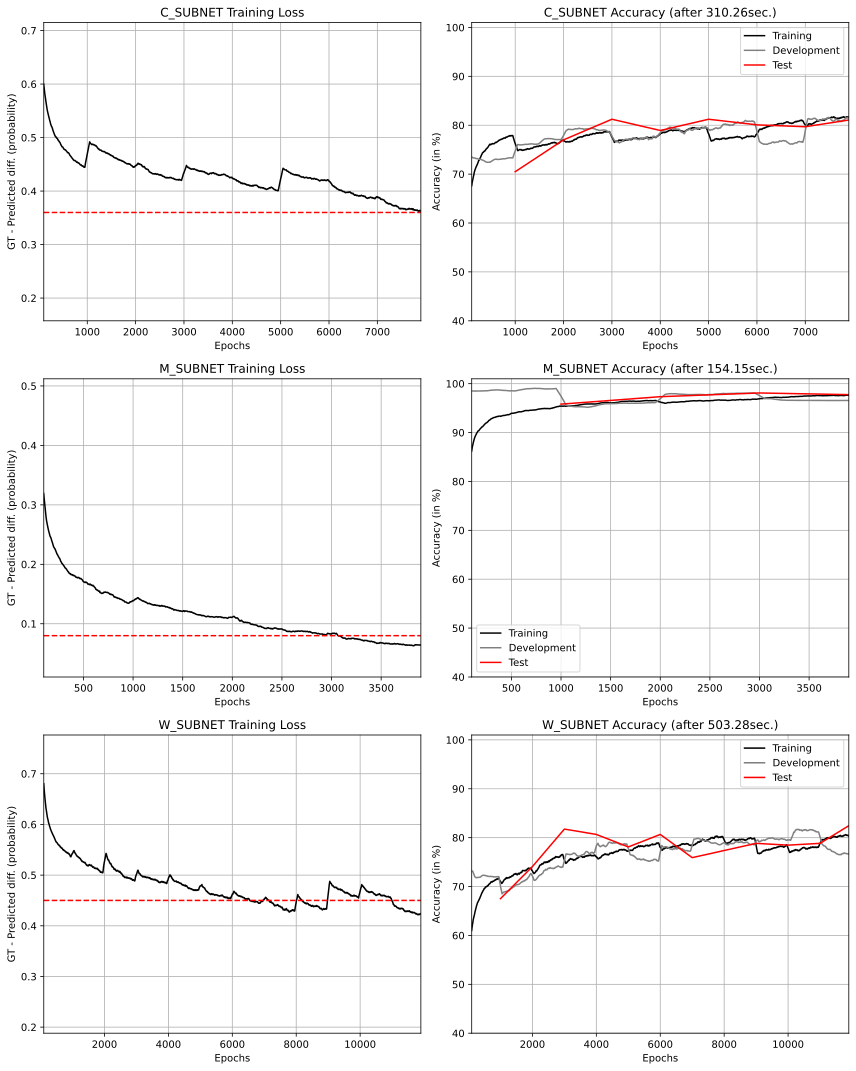

In [ ]:
# Training Phase Plots
plt.figure(figsize=(12, 5 * 3))

# loss_functions, training_accuracies, evaluation_accuracies, test_accuracies, training_times
classes = len(ocon_speakers)

for i in range(classes):
    plt.subplot(classes, 2, (i * 2) + 1)
    flat_loss_function = [item for sublist in loss_functions[i] for item in sublist]

    plt.plot(smooth(flat_loss_function), 'k-')
    plt.axhline(loss_breaks[i], color='r', linestyle='--')
    plt.title(f'{ocon_speakers[i].name.upper()} Training Loss')
    plt.xlabel('Epochs')
    plt.xlim([100, len(flat_loss_function) - 100])
    plt.ylabel('GT - Predicted diff. (probability)')
    plt.grid()

    plt.subplot(classes, 2, (i * 2) + 2)
    flat_training_accuracy = [item for sublist in training_accuracies[i] for item in sublist]
    flat_dev_accuracy = [item for sublist in evaluation_accuracies[i] for item in sublist]
    flat_test_accuracy = test_accuracies[i]

    plt.plot(smooth(flat_training_accuracy), 'k-', label='Training')
    plt.plot(smooth(flat_dev_accuracy), color='grey', label='Development')
    if len(flat_test_accuracy) > 1:
        plt.plot([(n + 1) * epochs for n in range(len(flat_test_accuracy))], flat_test_accuracy, 'r-', label=f'Test')
    else:
        plt.axhline(test_accuracy, color='r', linestyle='-', label=f'Test')
    plt.title(f'{ocon_speakers[i].name.upper()} Accuracy (after {training_times[i]:.2f}sec.)')
    plt.xlabel('Epochs')
    plt.xlim([100, len(flat_training_accuracy) - 100])
    plt.ylabel('Accuracy (in %)')
    plt.ylim([40, 101])
    plt.grid()
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig('OCON_training_phase')
plt.show()

In [ ]:
# OCON Evaluation

# Dataset & Labels Ordering (Plot conveniences)
x_data_minmax_ordered = np.zeros((1, x_data_minmax.shape[1]))
z_labels_raw_np_alt_ordered = np.zeros((1, 1), dtype='int')
data_size = []

# Groups Ordering iteration
for i in range(len(ocon_speakers)):
    indices = np.where(z_labels_raw_np_alt == i)[0]
    data_size.append(len(indices))

    x_data_minmax_ordered = np.vstack((x_data_minmax_ordered, x_data_minmax[indices]))
    z_labels_raw_np_alt_ordered = np.vstack((z_labels_raw_np_alt_ordered, z_labels_raw_np_alt[indices]))

x_data_minmax_ordered = np.delete(x_data_minmax_ordered, 0, axis=0)  # Remove 1st initialization null row
z_labels_raw_np_alt_ordered = np.delete(z_labels_raw_np_alt_ordered, 0, axis=0)  # Remove 1st initialization null label
print(f'Features Dataset Shapes : original {x_data_minmax.shape} VS ordered {x_data_minmax_ordered.shape}')
print(f'Labels Dataset Shapes   : original {z_labels_raw_np_alt.shape} VS ordered {z_labels_raw_np_alt_ordered.shape}')

ocon_predictions, ocon_dist_errors, ocon_eval_accuracies, ocon_g_truths = OCON_eval(ocon_speakers, features_dataset=x_data_minmax_ordered, labels=z_labels_raw_np_alt_ordered)

Features Dataset Shapes : original (1597, 13) VS ordered (1597, 13)
Labels Dataset Shapes   : original (1597, 1) VS ordered (1597, 1)
C_SUBNET Evaluation - Accuracy: 82.03%
M_SUBNET Evaluation - Accuracy: 97.75%
W_SUBNET Evaluation - Accuracy: 75.70%


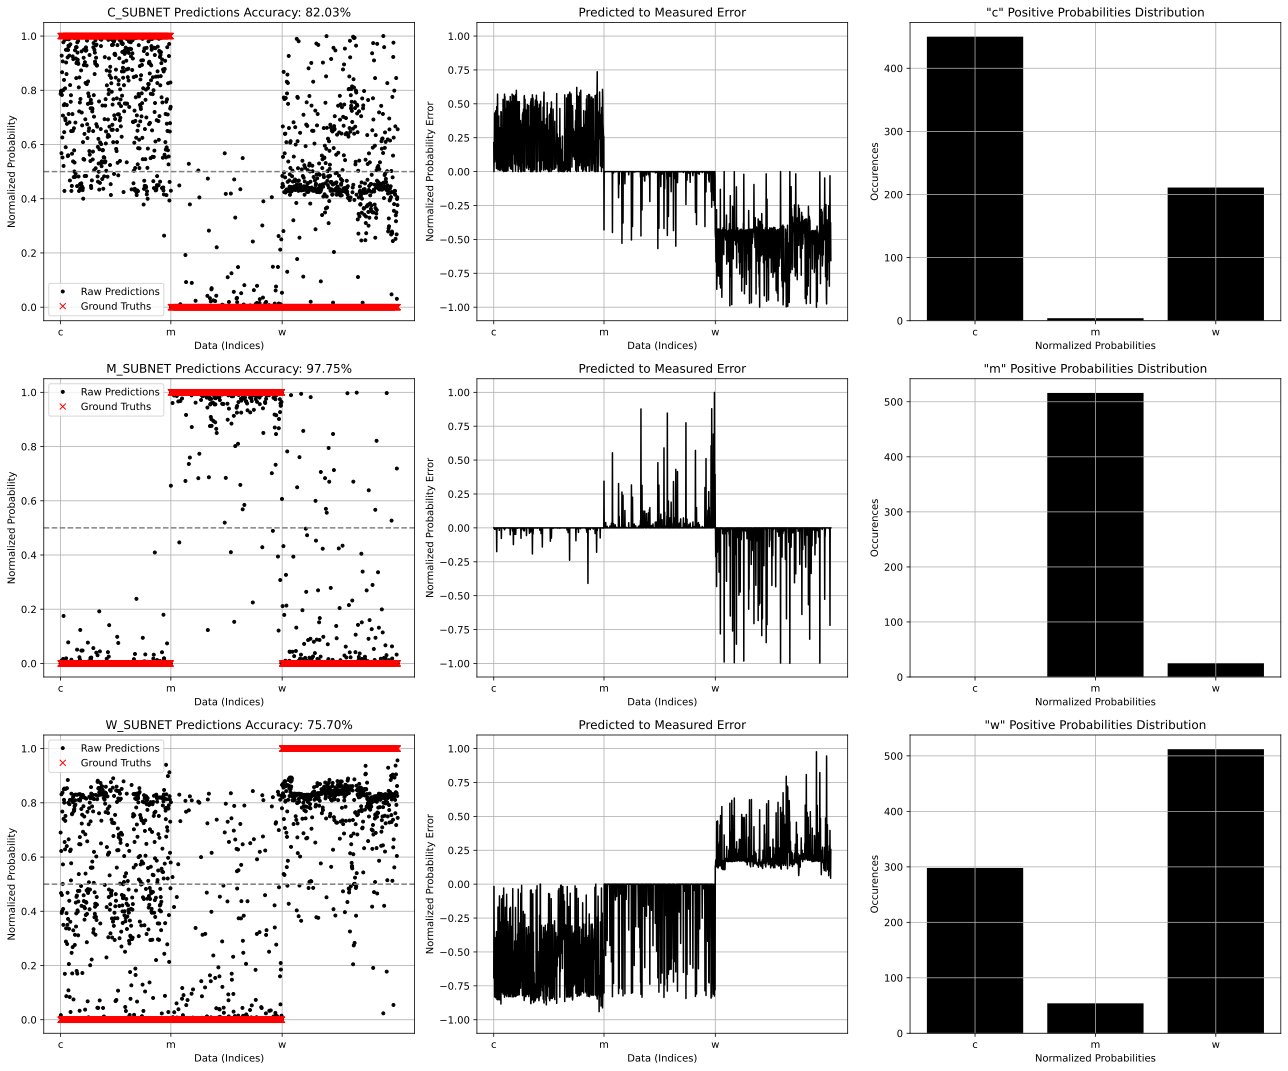

In [ ]:
# Dataset Evaluation Analysis Plot
plt.figure(figsize=(18, 5 * len(ocon_speakers)))
plot_ticks = []
for n in range(len(data_size)):
    plot_ticks.append(np.sum(data_size[: n], dtype='int'))

iter_idx = plot_ticks + [len(x_data_minmax_ordered)]

for i in range(len(ocon_speakers)):
    plt.subplot(len(ocon_speakers), 3, (i * 3) + 1)
    plt.plot(ocon_predictions[i], 'k.', label='Raw Predictions')
    plt.plot(ocon_g_truths[i], 'rx', label='Ground Truths')
    plt.axhline(0.5, linestyle='--', color='grey')
    plt.title(f'{ocon_speakers[i].name.upper()} Predictions Accuracy: {ocon_eval_accuracies[i]:.2f}%')
    plt.xlabel('Data (Indices)')
    plt.xticks(plot_ticks, speakers_alt)
    plt.ylabel('Normalized Probability')
    plt.grid()
    plt.legend(loc='best')

    plt.subplot(len(ocon_speakers), 3, (i * 3) + 2)
    plt.plot(ocon_dist_errors[i], 'k')
    plt.title(f'Predicted to Measured Error')
    plt.xlabel('Data (Indices)')
    plt.xticks(plot_ticks, speakers_alt)
    plt.ylabel('Normalized Probability Error')
    plt.ylim([-1.1, 1.1])
    plt.grid()

    plt.subplot(len(ocon_speakers), 3, (i * 3) + 3)

    # Predictions list processing
    predictions_temp = ocon_predictions[i]
    class_predictions = [item for sublist in predictions_temp for item in sublist]  # Turn a list of lists in a single list (of tensors)
    for j in range(len(class_predictions)):  # Turn a list of tensors of one variable in a list of scalars (item() method)
        class_predictions[j] = class_predictions[j].item()

    # Positives & False-Positives extraction
    positives = []
    for w in range(len(speakers_alt)):
        num = (np.array(class_predictions[iter_idx[w]: iter_idx[w + 1]]) > 0.5).sum()
        positives.append(num)

    plt.bar(np.arange(len(speakers_alt)), positives, color='k')
    plt.title(f'"{speakers_alt[i]}" Positive Probabilities Distribution')
    plt.xlabel('Normalized Probabilities')
    plt.ylabel('Occurences')
    plt.xticks([n for n in range(3)], speakers_alt)
    plt.grid()

plt.tight_layout()
plt.savefig('OCON_bank_evaluation')
plt.show()

In [ ]:
# Model Parameters Save/Load functions
from pathlib import Path

def save_model_state(model, folder_name: str = "Trained_models_state"):
    """
    Save Pre-Trained model parameters in a State Dictionary
    """

    MODEL_PATH = Path(folder_name)  # Placed in root
    MODEL_PATH.mkdir(parents=True, exist_ok=True)  # Pre-existing folder (w. same name) monitoring
    MODEL_NAME = '{}_{}'.format(model.name, "Params.pth")
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    print(f"Saving {model.name} Parameters in: {MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

    return MODEL_SAVE_PATH

# Save Pre-Trained Models-bank
states_path = []  # Path for each model parameters state
for i in range(len(ocon_speakers)):
    state_path = save_model_state(ocon_speakers[i])
    states_path.append(state_path)
print()

Saving c_subnet Parameters in: Trained_models_state/c_subnet_Params.pth
Saving m_subnet Parameters in: Trained_models_state/m_subnet_Params.pth
Saving w_subnet Parameters in: Trained_models_state/w_subnet_Params.pth



### Output **Maxnet Algorithm**

In [ ]:
# OCON "MaxNet" Architecture (Weightening + Non Linearity apply)
class OCON_MaxNet(nn.Module):                                             # nn.Module: base class to inherit from
    def __init__(self, n_units, act_fun, eps):                                 # self + attributes (architecture hyper-parameters)
        super().__init__()

        self.layers = nn.ModuleDict()                                     # Dictionary to store Model layers
        self.eps_weight = eps

        # MaxNet Layer
        self.layers['MAXNET'] = nn.Linear(n_units, n_units)               # Key 'MaxNet' layer specification

        # Weights & Bias initialization
        self.layers['MAXNET'].weight.data.fill_(self.eps_weight)
        for i in range(n_units):
            self.layers['MAXNET'].weight[i][i].data.fill_(1.)  # Self Weight = 1

        self.layers['MAXNET'].bias.data.fill_(0.)

        # Activation Function
        self.actfun = act_fun  # Function string-name attribute association

    # Forward Pass Method
    def forward(self, x):

        # Activation function object computation
        actfun = getattr(torch.nn, self.actfun)

        # Maxnet Layer pass                                               --> Output Weightening (Dot Product) "Linear transform" + Non Linearity Activation Function
        x = actfun()(self.layers['MAXNET'](x.squeeze().float()))

        # Self

        return x

In [ ]:
# Build OCON MaxNetwork Architecture
torch.manual_seed(SEED)
ocon_maxnet = OCON_MaxNet(n_units=3, act_fun='ReLU', eps=0.25)

# MaxNet & Sub-Networks Parameters
print('OCON MaxNet STATE')
model_desc(ocon_maxnet)

OCON MaxNet STATE
Params Description:
Parameter Name      : layers.MAXNET.weight
Parameter Weights   : tensor([[1.0000, 0.2500, 0.2500],
        [0.2500, 1.0000, 0.2500],
        [0.2500, 0.2500, 1.0000]], grad_fn=<SliceBackward0>)
...with 9 TRAINABLE parameters
................................
Parameter Name      : layers.MAXNET.bias
Parameter Weights   : tensor([0., 0., 0.], grad_fn=<SliceBackward0>)
...with 3 TRAINABLE parameters
................................
----------------------------------------------------------------
Total Nodes             : 3
----------------------------------------------------------------


In [ ]:
def maxnet_algo(maxnet_function, n_units, act_fun, eps, input_array):
    """
    MaxNet Re-iteration algorithm for Maximum Value retrieving from an input array
    """
    non_zero_outs = np.count_nonzero(input_array)  # Non Zero Values initialization
    maxnet_in = torch.from_numpy(input_array)  # MaxNet Input Tensor initialization

    results = []  # Results initialization

    counter = 0
    while non_zero_outs != 1:
        counter += 1

        # Create the MaxNet
        torch.manual_seed(SEED)  # Redundant
        maxnet = maxnet_function(n_units = n_units, act_fun = act_fun, eps = eps)

        # Compute Forward Pass
        results = maxnet(maxnet_in)

        # Non_zero outputs & Maxnet Input Update
        non_zero_outs = np.count_nonzero(results.detach().numpy())
        maxnet_in = results.detach()  # Save results for next iteration

    print(f'Maximum Value found in {counter} iterations')
    return np.argmax(results.detach().numpy())

In [ ]:
# MaxNet on Sub-Networks predictions
ocon_predictions_prob = np.zeros((len(ocon_predictions), x_data_minmax_ordered.shape[0]))  # NumPy predictions matrix (12 * 1617)

# Convert from List of Tensors to 2D NumPy Array
for i in range(len(ocon_predictions)):
    ocon_predictions_prob[i, :] = ocon_predictions[i].detach().squeeze().numpy()

maxnet_class_predictions = []  # Classes Outputs list initialization
# MaxNet application
for i in range(x_data_minmax.shape[0]):
    print(f'Dataset Sample({i + 1}) Class Evaluation')

    samp_predictions = ocon_predictions_prob[:, i]  # Array of 12 predictions for each Dataset sample (OCON outputs)
    class_prediction = maxnet_algo(OCON_MaxNet, n_units=3, act_fun='ReLU', eps=-0.1, input_array=samp_predictions)  # MaxNet Computation
    maxnet_class_predictions.append(class_prediction)  # Result appending
    print('-----------------------------------------------')

maxnet_accuracy = 100 * np.mean((np.array(maxnet_class_predictions).reshape(1597, 1) == z_labels_raw_np_alt_ordered))  # Accuracy computation
print(f'Maxnet Output --> Speaker ACCURACY: {maxnet_accuracy}%')

Dataset Sample(1) Class Evaluation
Maximum Value found in 14 iterations
-----------------------------------------------
Dataset Sample(2) Class Evaluation
Maximum Value found in 1 iterations
-----------------------------------------------
Dataset Sample(3) Class Evaluation
Maximum Value found in 7 iterations
-----------------------------------------------
Dataset Sample(4) Class Evaluation
Maximum Value found in 11 iterations
-----------------------------------------------
Dataset Sample(5) Class Evaluation
Maximum Value found in 9 iterations
-----------------------------------------------
Dataset Sample(6) Class Evaluation
Maximum Value found in 5 iterations
-----------------------------------------------
Dataset Sample(7) Class Evaluation
Maximum Value found in 7 iterations
-----------------------------------------------
Dataset Sample(8) Class Evaluation
Maximum Value found in 5 iterations
-----------------------------------------------
Dataset Sample(9) Class Evaluation
Maximum Val

In [ ]:
# Argmax on Sub-Networks predictions (...for multiple 1s probabilities MaxNet infinite loops)
#ocon_predictions_prob = np.zeros((len(new_ocon_predictions), x_data_minmax.shape[0]))  # NumPy predictions matrix (12 * 1617)
#
# Convert from List of Tensors to 2D NumPy Array
#for i in range(len(new_ocon_predictions)):
#    ocon_predictions_prob[i, :] = new_ocon_predictions[i].detach().squeeze().numpy()
#
#maxnet_class_predictions = np.argmax(ocon_predictions_prob, axis=0)
#maxnet_accuracy = 100 * np.mean((np.array(maxnet_class_predictions).reshape(1617, 1) == y_labels_raw_np))  # Accuracy computation
#print(f'Maxnet Output ACCURACY: {maxnet_accuracy}%')

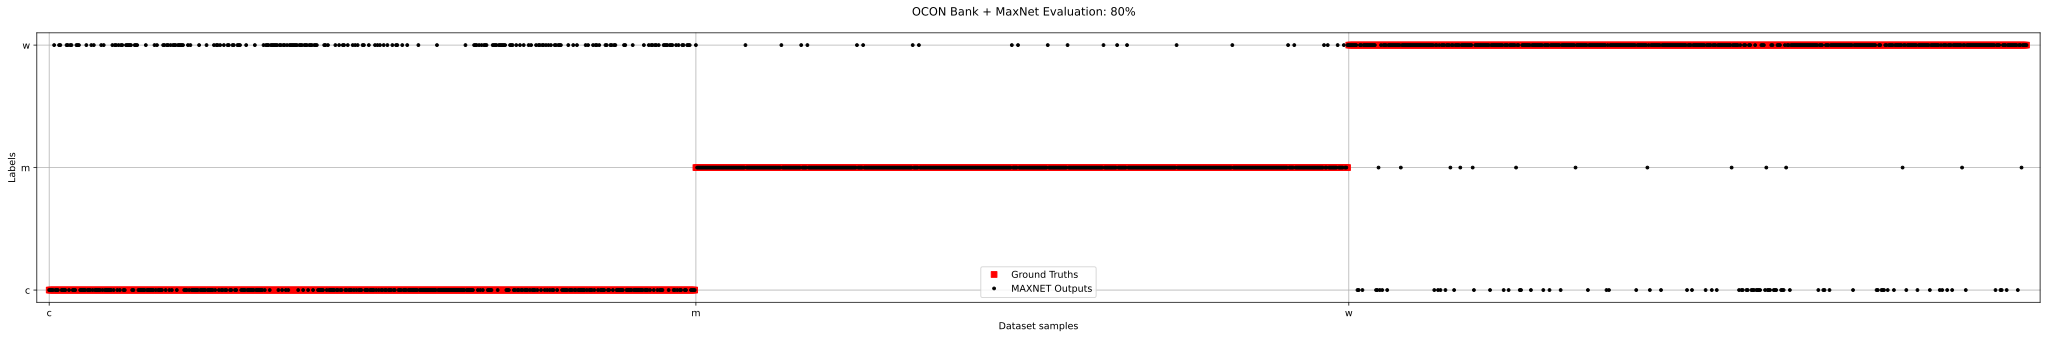

In [ ]:
# Evaluation Analysis Plot
plt.figure(figsize=(30, 5))
plt.suptitle(f'OCON Bank + MaxNet Evaluation: {maxnet_accuracy:.0f}%')

plot_y_ticks = [n for n in range(len(speakers_alt))]

plt.plot(z_labels_raw_np_alt_ordered, 'rs', label='Ground Truths')
plt.plot(maxnet_class_predictions, 'k.', label='MAXNET Outputs')
plt.xlabel('Dataset samples')
plt.xticks(ticks=plot_ticks, labels=speakers_alt)
plt.xlim([-10, len(y_labels_raw_np) + 10])
plt.ylabel('Labels')
plt.yticks(ticks=plot_y_ticks, labels=speakers_alt)
plt.legend(loc='best')
plt.grid()

plt.tight_layout()
plt.savefig('OCON_model_evaluation')
plt.show()